In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('cleaned_for_pipeline.csv')
df.head()

,Unnamed: 0,Area_Service,Age,Gender,Cultural_group,ethnicity,Admission_type,Home_or_Selfcare,ccs_procedure_code,Code_illness,Mortality_risk,Surg_Description,Weight_baby,Emergency_dept_yes_No,Tot_charg,ratio_of_total_costs_to_total_charges,Result,Payment_Typology
0,0,Western NY,30 to 49,F,White,Not Span/Hispanic,Elective,Home or Self Care,0,1,1.0,Medical,0,Y,5511.95,1.012798,1,1
1,1,Western NY,70 or Older,F,White,Not Span/Hispanic,Urgent,Short-term Hospital,0,3,2.0,Medical,0,Y,4783.20,1.079365,1,1
2,2,Western NY,30 to 49,F,White,Not Span/Hispanic,Urgent,Home or Self Care,0,1,1.0,Medical,0,Y,3829.15,1.059379,1,1
3,3,Western NY,0 to 17,F,White,Not Span/Hispanic,Urgent,Home or Self Care,0,1,1.0,Medical,0,Y,1108.20,1.484167,0,1
4,4,Western NY,70 or Older,F,White,Not Span/Hispanic,Elective,Home or Self Care,0,2,3.0,Medical,0,Y,3418.18,0.986161,1,1


In [3]:
df.drop(columns=['Unnamed: 0'], axis=1,inplace=True)

In [4]:
#Dividing the target and independent columns

In [5]:
x = df.drop(columns=['Result'])
y = df['Result']

**Balancing the data.**

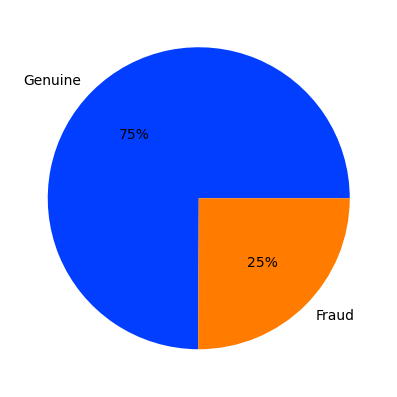

In [6]:
labels = ['Genuine','Fraud']
colors = sns.color_palette('bright')[0:5]

plt.figure(figsize=(10,5), dpi=100)
plt.pie(y.value_counts(), labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [31]:
from imblearn.over_sampling import RandomOverSampler

In [32]:
oversampled = RandomOverSampler(sampling_strategy='minority')
x_res,y_res = oversampled.fit_resample(x,y)

In [33]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({1: 742270, 0: 248222})
Resampled dataset shape Counter({1: 742270, 0: 742270})


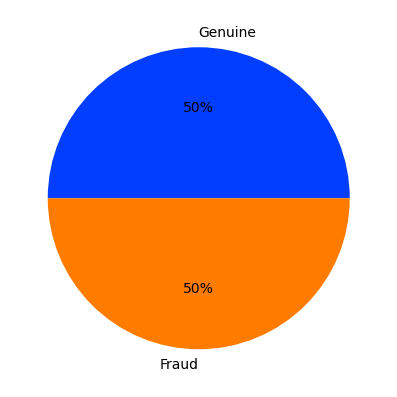

In [35]:
plt.figure(figsize=(10,5),dpi=100)
plt.pie(y_res.value_counts(), labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [36]:
print(x_res.shape)
print(y_res.shape)

(1484540, 16)
(1484540,)


# Creating a Pipeline

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import set_config
set_config(display='diagram')

In [38]:
df.head(2)

,Area_Service,Age,Gender,Cultural_group,ethnicity,Admission_type,Home_or_Selfcare,ccs_procedure_code,Code_illness,Mortality_risk,Surg_Description,Weight_baby,Emergency_dept_yes_No,Tot_charg,ratio_of_total_costs_to_total_charges,Result,Payment_Typology
0,Western NY,30 to 49,F,White,Not Span/Hispanic,Elective,Home or Self Care,0,1,1.0,Medical,0,Y,5511.95,1.012798,1,1
1,Western NY,70 or Older,F,White,Not Span/Hispanic,Urgent,Short-term Hospital,0,3,2.0,Medical,0,Y,4783.20,1.079365,1,1


In [39]:
transformer = ColumnTransformer(transformers=[
    ('tnf1',OneHotEncoder(sparse=False, handle_unknown='ignore'), [0,1,2,3,4,5,6,10]),
    ('tnf2',OrdinalEncoder(categories=[['Y','N']]),[12]),
],remainder='passthrough')

In [41]:
x_train,x_test,y_train,y_test = train_test_split(x_res,y_res,test_size=0.2,random_state=42)

In [42]:
rf_model = Pipeline(steps=[('transformer',transformer),
                           ('model', RandomForestClassifier(n_estimators=150))
                          ])

In [43]:
y_train.value_counts()

1    594093
0    593539
Name: Result, dtype: int64

In [44]:
y_test.value_counts()

0    148731
1    148177
Name: Result, dtype: int64

In [45]:
rf_model.fit(x_train,y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tnf1',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [0, 1, 2, 3, 4, 5, 6, 10]),
                                                 ('tnf2',
                                                  OrdinalEncoder(categories=[['Y',
                                                                              'N']]),
                                                  [12])])),
                ('model', RandomForestClassifier(n_estimators=150))])

In [46]:
rf_y_pred = rf_model.predict(x_test)
rf_y_pred

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [47]:
rf_pred_train= rf_model.predict(x_train)
print("Accuracy of training model",accuracy_score(y_train,rf_pred_train))
print("==============================================================================")
print("Confusion Matrics",confusion_matrix(y_train,rf_pred_train))
print("==============================================================================")
print("Classificaton Report ",classification_report(y_train,rf_pred_train))

Accuracy of training model 0.9986847777762808
Confusion Matrics [[593306    233]
 [  1329 592764]]
Classificaton Report                precision    recall  f1-score   support

           0       1.00      1.00      1.00    593539
           1       1.00      1.00      1.00    594093

    accuracy                           1.00   1187632
   macro avg       1.00      1.00      1.00   1187632
weighted avg       1.00      1.00      1.00   1187632



In [48]:
rf_pred_test= rf_model.predict(x_test)
print("Accuracy of testing model",accuracy_score(y_test,rf_pred_test))
print("==============================================================================")
print("Confusion Matrics",confusion_matrix(y_test,rf_pred_test))
print("==============================================================================")
print("Classificaton Report",classification_report(y_test,rf_pred_test))

Accuracy of testing model 0.8656553545205923
Confusion Matrics [[137344  11387]
 [ 28501 119676]]
Classificaton Report               precision    recall  f1-score   support

           0       0.83      0.92      0.87    148731
           1       0.91      0.81      0.86    148177

    accuracy                           0.87    296908
   macro avg       0.87      0.87      0.87    296908
weighted avg       0.87      0.87      0.87    296908



In [49]:
def unique(x):
    print(*Counter(x))

In [50]:
unique(rf_y_pred)

1 0


In [52]:
import pickle
pickle.dump(rf_model, open('rf_model.pkl', 'wb'))